In [108]:
import networkx
import numpy
import pandas as pd
import numpy as np
from networkx.readwrite import json_graph
import json
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style
from matplotlib import pyplot
import seaborn as sns
import scipy.stats
from bs4 import BeautifulSoup
import re
import csv
import requests
import time
from time import sleep
from random import randint
from sklearn.linear_model import LinearRegression

In [109]:
pages = [str(i) for i in range(1,7)]
movie_name_array=[]
year_list = []
certificate_array = []
duration_array = []
rating_array = []
genre_array = []
votes_array = []
gross_array = []
budget_list=[]
language_list=[]
country_list=[]  
for page in pages:
    page_url ="https://www.imdb.com/list/ls062911411/?st_dt=&mode=detail&page="+page+"&sort=list_order,asc"
    response = requests.get(page_url)
    sleep(randint(8,15))
    soup = BeautifulSoup(response.content,"html.parser")
    movie_name = soup.find_all("h3",class_="lister-item-header")
   # movie_name_array=[]
    for i in movie_name:
        box1=i.get_text()
        box1=re.findall("\\n.+\\n(.+)\\n.+\\n",box1)
        movie_name_array.append(box1[0])
    
    year = soup.find_all("span",class_="lister-item-year")
    #year_list = []
    for i in year:
        y1=i.get_text()
        y2 = re.sub(r"[\D]","",y1)
        #print(y2)
        year_list.append(y2)
   
    certificate = soup.find_all("p", class_="text-muted text-small")
    certificate_cleaned=[]
    
    for x in range(len(certificate)):
        if x%3==0:
            certificate_cleaned.append(certificate[x])
    for i in certificate_cleaned:
        if i.find("span", class_="certificate")!=None:
            certificate_1=i.find("span",class_="certificate")
            certificate_array.append(certificate_1.get_text())
        else:
            certificate_array.append("Not found")
    
    duration = soup.find_all("span",class_="runtime")
    
    for i in duration:
        duration_array.append(float(re.findall("\d+",i.get_text())[0]))

    rating = soup.find_all('div',class_="ipl-rating-star small")
   
    for r in rating:
        try:
            rating_1=r.find("span", class_="ipl-rating-star__rating")
            rating_array.append(rating_1.getText())
        except:
            rating_array.append(0)
   
    genre = soup.find_all('span',class_="genre")
   
    for g in genre:
        genre_array.append(str(g.get_text()[1:].rstrip()))

    votes = soup.find_all('p',class_="text-muted text-small")
    votes_cleaned = []

    for x in range(len(votes)):
        if x%3==2:
            votes_cleaned.append(votes[x])
    for v in votes_cleaned:
        votes_data = v.find_all('span')
        names1 = votes_data[1].get_text().replace(',','')
        votes_array.append(int(names1))
        try:
            names2 = votes_data[4].get("data-value").replace(',','')
            gross_array.append(float(names2))
        except:
            gross_array.append(0)
    
    
    links = []
    titles = []
    newlinks = []
    
    for link in soup.find_all('a'):
        links.append(link.get('href'))
    #print(links)
        r = re.search('/title/(tt\d{5,7})/',str(link.get('href')))
        if r is not None:
            #print(r.group())
            #print("\n")
            newlinks.append(r.group())
    
    #print(newlinks)
    newtitle = []
    #print(newlinks)
    for i in range(len(newlinks)):
        if i%2 == 0:
            newtitle.append(newlinks[i])
    newtitle = newtitle[:]
    #print(newtitle)
    if page_url == "https://www.imdb.com/list/ls062911411/?sort=list_order,asc&st_dt=&mode=detal&page=5":
        newtitle.remove("/title/tt0118843/plotsummary")
    #print(newtitle)    
    for specific in newtitle:
        #print(specific)
        url = "https://www.imdb.com"+specific+"?ref_=ttls_li_tt"
        single_response = requests.get(url)
        single_soup = BeautifulSoup(single_response.content, "html.parser")
        text_box = single_soup.find_all('div',class_="txt-block")
        
        if(single_soup.find(text="Budget:") is None):
           # print("123")
            budget_list.append(0)
        elif (single_soup.find(text="Language:") is None):
            language_list.append("No Specific")
          #  print("1234")

        for c in text_box:
           # print(text_box)
            try:
                heading=c.find('h4').getText()
                if heading == "Country:":
                    c1=c.find('a').getText()
                    country_list.append(c1)
                if heading == "Language:":
                    c2=c.find('a').getText()
                    language_list.append(c2)

                if heading == "Budget:":
                    c3=c.find('h4').next_sibling
                    c4=c3.rstrip()
                    budget_list.append(c4)
            except:
                continue

In [110]:
with open ('movie_review.csv','w',newline='',encoding='utf-8') as file:
    #file.write('\ufeff')
    writer=csv.writer(file)
    writer.writerow(['Movie Name','Certificate','Duration','Year','Rating','Genre','Budget','Gross','Language','Country'])
    rows = zip(movie_name_array,certificate_array,duration_array,year_list, rating_array, genre_array, budget_list,gross_array,language_list,country_list)
    for row in rows:
        writer.writerow(row)

In [143]:
df = pd.read_csv('movie_review.csv',encoding='utf-8')

In [144]:
budgetvalue = []
for i in df['Budget']:
    jp = re.match("JPY",i)
    ru = re.match("RUR",i)
    kr = re.match("KRW",i)
    it = re.match("ITL",i)
    trl = re.match("TRL",i)
    dem = re.match("DEM",i)
    frf = re.match("FRF",i)
    
    i = re.sub("[^\d]+","",i)
    if jp:
        i = int(i)*0.0096
    if ru:
        i = int(i)*0.014
    if kr:
        i = int(i)*0.00084
    if it:
        i = int(i)*0.000001
    if trl:
        i = int(i)*0.16
    if dem:
        i = int(i)*0.002439
    if frf:
        i = int(i)*0.1736
    budgetvalue.append(int(i))
    
df['Budget Value'] = budgetvalue

In [145]:
df.describe()

,Duration,Year,Rating,Gross,Budget Value
count,517.000000,517.000000,517.000000,5.170000e+02,5.170000e+02
mean,122.549323,1982.286267,8.049903,6.414797e+07,2.253193e+07
std,29.088611,25.593711,0.305988,1.033734e+08,4.061178e+07
min,45.000000,1916.000000,7.100000,0.000000e+00,0.000000e+00
25%,102.000000,1962.000000,7.900000,7.520450e+05,1.000000e+06
50%,118.000000,1987.000000,8.000000,2.224586e+07,6.000000e+06
75%,137.000000,2004.000000,8.200000,8.340000e+07,2.200000e+07
max,238.000000,2018.000000,9.300000,9.366622e+08,2.450000e+08


In [146]:
#df.loc[df['Budget Value']==0.0, 'Budget Value'] = df['Gross']

In [147]:
#df.describe()

In [148]:
#Replacing '0' values with 'mean' value taken from df.describe above and dividing by 1000000 for easy comparison with Rating
df['Gross'].replace(0.0, 64147970,inplace=True)  
df['Gross'] = df['Gross']/1000000
df['Budget Value'].replace(0.0, 22531930,inplace=True)
df['Budget Value'] = df['Budget Value']/1000000

In [149]:
before_data = df[(df['Year']<2000)]
before_data.head(10)

,Movie Name,Certificate,Duration,Year,Rating,Genre,Budget,Gross,Language,Country,Budget Value
0,Citizen Kane,PG,119.0,1941,8.3,"Drama, Mystery","$839,727",1.585634,English,USA,0.839727
1,The Godfather,M18,175.0,1972,9.2,"Crime, Drama","$6,000,000",134.966411,English,USA,6.000000
2,The Wizard of Oz,G,102.0,1939,8.0,"Adventure, Family, Fantasy","$2,777,000",2.076020,English,USA,2.777000
3,The Shawshank Redemption,R(A),142.0,1994,9.3,Drama,"$25,000,000",28.341469,English,USA,25.000000
4,Pulp Fiction,R,154.0,1994,8.9,"Crime, Drama","$8,000,000",107.928762,English,USA,8.000000
5,Casablanca,PG,102.0,1942,8.5,"Drama, Romance, War","$950,000",1.024560,English,USA,0.950000
6,The Third Man,Not found,104.0,1949,8.1,"Film-Noir, Mystery, Thriller",0,0.449191,English,UK,22.531930
7,Star Wars: Episode V - The Empire Strikes Back,PG,124.0,1980,8.7,"Action, Adventure, Fantasy","$18,000,000",290.475067,English,USA,18.000000
8,Schindler's List,R(A),195.0,1993,8.9,"Biography, Drama, History","$22,000,000",96.898818,English,USA,22.000000
9,Apocalypse Now,R,147.0,1979,8.4,"Drama, Mystery, War","$31,500,000",83.471511,English,USA,31.500000


In [150]:
after_data = df[(df['Year']>2000)]
after_data.head(10)

,Movie Name,Certificate,Duration,Year,Rating,Genre,Budget,Gross,Language,Country,Budget Value
27,The Dark Knight,PG,152.0,2008,9.0,"Action, Crime, Drama","$185,000,000",534.858444,English,USA,185.0
35,12 Years a Slave,M18,134.0,2013,8.1,"Biography, Drama, History","$20,000,000",56.671993,English,UK,20.0
41,The Lord of the Rings: The Fellowship of the Ring,PG,178.0,2001,8.8,"Action, Adventure, Drama","$93,000,000",315.544750,English,New Zealand,93.0
45,Spotlight,NC16,129.0,2015,8.1,"Biography, Crime, Drama","$20,000,000",45.055776,English,USA,20.0
47,Moonlight,M18,111.0,2016,7.4,Drama,"$4,000,000",27.850912,English,USA,4.0
49,The Lord of the Rings: The Return of the King,PG,201.0,2003,8.9,"Adventure, Drama, Fantasy","$94,000,000",377.845905,English,New Zealand,94.0
65,Gravity,PG13,91.0,2013,7.7,"Drama, Sci-Fi, Thriller","$100,000,000",274.092705,English,UK,100.0
85,Selma,PG13,128.0,2014,7.5,"Biography, Drama, History","$20,000,000",52.076908,English,UK,20.0
94,The Hurt Locker,M18,131.0,2008,7.6,"Drama, Thriller, War","$15,000,000",17.017811,English,USA,15.0
96,Mad Max: Fury Road,NC16,120.0,2015,8.1,"Action, Adventure, Sci-Fi","$150,000,000",154.058340,English,Australia,150.0


## Duration Distribution

In [151]:
df.sort_values(['Duration'], ascending=False, axis=0, inplace=True)

In [152]:
# np.histogram returns 2 values
count, bin_edges = np.histogram(df['Duration'])

print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins

[  2  18 118 157 112  51  36  14   6   3]
[ 45.   64.3  83.6 102.9 122.2 141.5 160.8 180.1 199.4 218.7 238. ]


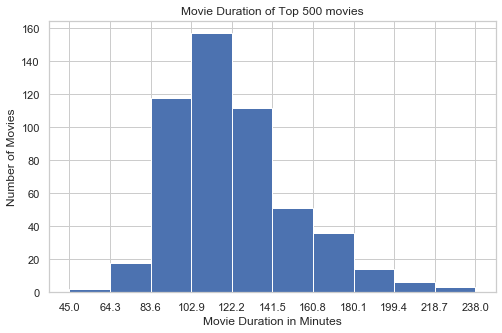

In [153]:
df['Duration'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)

plt.title('Movie Duration of Top 500 movies')
plt.ylabel('Number of Movies') # add y-label
plt.xlabel('Movie Duration in Minutes') # add x-label

plt.show()

## Gross Value Distribution

In [154]:
df.sort_values(['Gross'], ascending=False, axis=0, inplace=True)
# np.histogram returns 2 values
count, bin_edges = np.histogram(df['Gross'])

print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins


[397  65  30  14   7   1   1   1   0   1]
[8.06000000e-03 9.36734765e+01 1.87338893e+02 2.81004310e+02
 3.74669726e+02 4.68335143e+02 5.62000559e+02 6.55665976e+02
 7.49331392e+02 8.42996809e+02 9.36662225e+02]


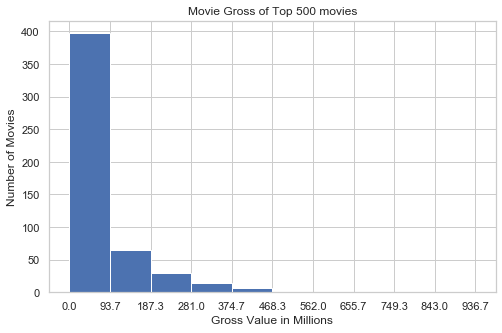

In [155]:
df['Gross'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)

plt.title('Movie Gross of Top 500 movies')
plt.ylabel('Number of Movies') # add y-label
plt.xlabel('Gross Value in Millions') # add x-label

plt.show()

## Budget Value Distribution

In [156]:
df.sort_values(['Budget Value'], ascending=False, axis=0, inplace=True)
df.head()

,Movie Name,Certificate,Duration,Year,Rating,Genre,Budget,Gross,Language,Country,Budget Value
310,Star Wars: Episode VII - The Force Awakens,PG,138.0,2015,7.9,"Action, Adventure, Sci-Fi","$245,000,000",936.662225,English,USA,245.0
407,The Avengers,PG,143.0,2012,8.0,"Action, Adventure, Sci-Fi","$220,000,000",623.279547,English,USA,220.0
230,Titanic,NC-16,194.0,1997,7.8,"Drama, Romance","$200,000,000",659.325379,English,USA,200.0
236,Toy Story 3,PG,103.0,2010,8.3,"Animation, Adventure, Comedy","$200,000,000",415.004880,English,USA,200.0
338,Skyfall,PG,143.0,2012,7.7,"Action, Adventure, Thriller","$200,000,000",304.360277,English,UK,200.0


[392  56  22  12  10   4   9   7   4   1]
[2.9000000e-03 2.4502610e+01 4.9002320e+01 7.3502030e+01 9.8001740e+01
 1.2250145e+02 1.4700116e+02 1.7150087e+02 1.9600058e+02 2.2050029e+02
 2.4500000e+02]


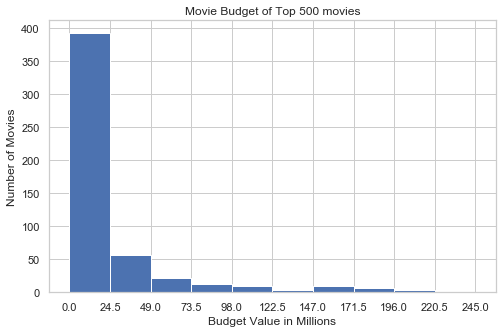

In [157]:
# np.histogram returns 2 values
count, bin_edges = np.histogram(df['Budget Value'])

print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins
df['Budget Value'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)

plt.title('Movie Budget of Top 500 movies')
plt.ylabel('Number of Movies') # add y-label
plt.xlabel('Budget Value in Millions') # add x-label

plt.show()

In [158]:
# count how many movies have each of the content ratings
df[['Certificate','Movie Name']].groupby('Certificate').count()

,Movie Name
Certificate,
(Banned),3
G,28
M18,67
NC-16,56
NC16,11
Not found,71
PG,209
PG-13,2
PG13,18


## Certificate Distribution

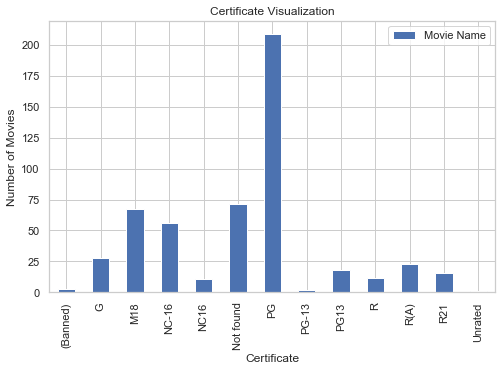

In [159]:
df[['Certificate','Movie Name']].groupby('Certificate').count().plot(kind='bar',figsize=(8, 5), title='Certificate Visualization')
plt.xlabel('Certificate')
plt.ylabel('Number of Movies')
plt.show()

## Year Distribution

[  8  18  33  40  52  55  58  63  87 103]
[1916.  1926.2 1936.4 1946.6 1956.8 1967.  1977.2 1987.4 1997.6 2007.8
 2018. ]


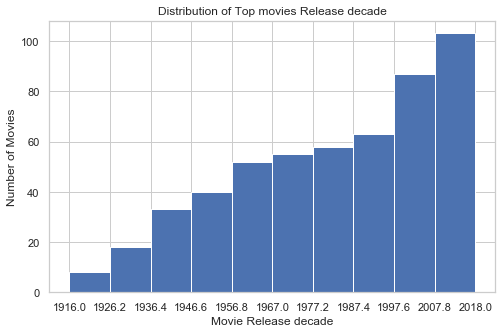

In [160]:
df.sort_values(['Year'], ascending=False, axis=0, inplace=True)
# np.histogram returns 2 values
count, bin_edges = np.histogram(df['Year'])

print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins
df['Year'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)

plt.title('Distribution of Top movies Release decade')
plt.ylabel('Number of Movies') # add y-label
plt.xlabel('Movie Release decade') # add x-label

plt.show()

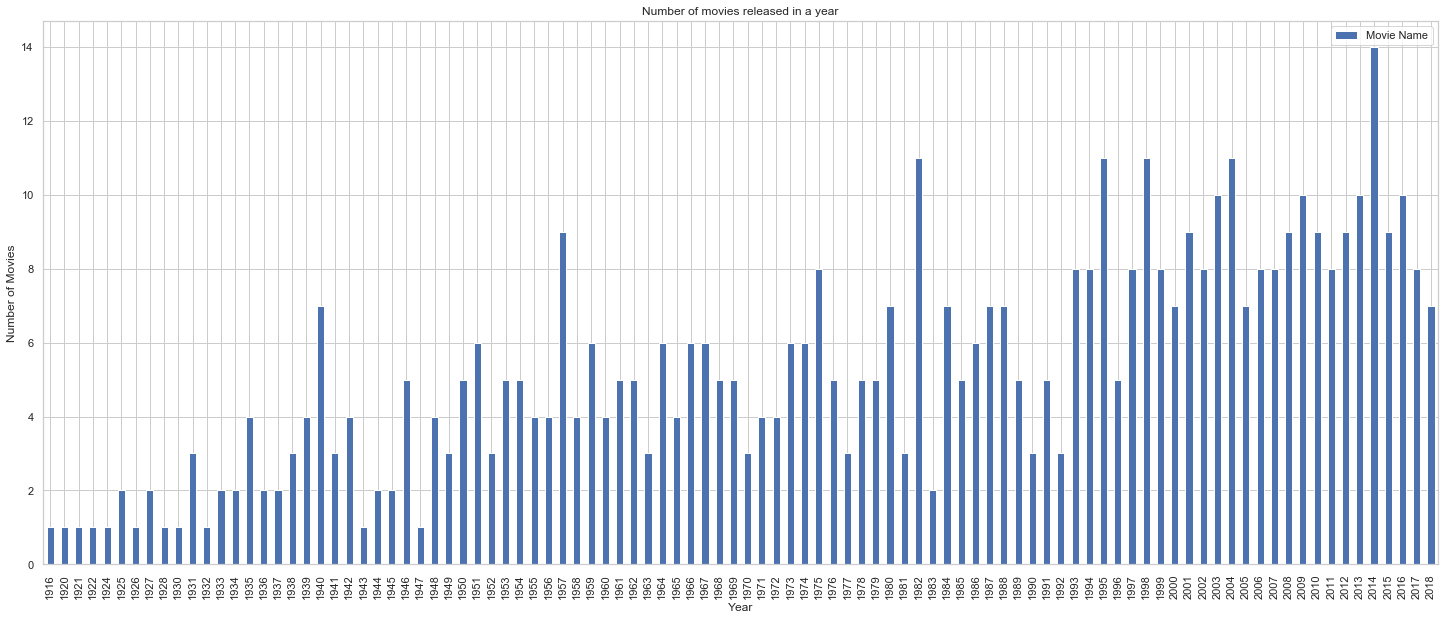

In [161]:
df[['Year','Movie Name']].groupby('Year').count().plot(kind='bar',figsize=(25, 10), title='Number of movies released in a year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.show()

## Genre Distribution

In [162]:
genre_list = []
for genre_val in df['Genre']:
    genre_list.append([e.strip() for e in genre_val.split(',')])
#Declare a dictionary and see if the actor name key exist and then count accordingly.
genre_dict = {}
for genre_val in genre_list:
    for a in genre_val:
        if a in genre_dict:
            genre_dict[a] +=1
        else:
            genre_dict[a] = 1

genre_dict


{'Animation': 46,
 'Adventure': 104,
 'Comedy': 106,
 'Drama': 364,
 'Action': 72,
 'Horror': 24,
 'Mystery': 55,
 'Biography': 51,
 'Crime': 82,
 'Thriller': 70,
 'History': 35,
 'Sci-Fi': 50,
 'Romance': 74,
 'Family': 29,
 'Music': 13,
 'Sport': 8,
 'Western': 17,
 'Fantasy': 35,
 'Documentary': 3,
 'War': 32,
 'Musical': 9,
 'Film-Noir': 14}

In [163]:
df_genre = pd.DataFrame.from_dict(genre_dict,orient='index',columns=['Genre Count'])
df_genre.head()

,Genre Count
Animation,46
Adventure,104
Comedy,106
Drama,364
Action,72


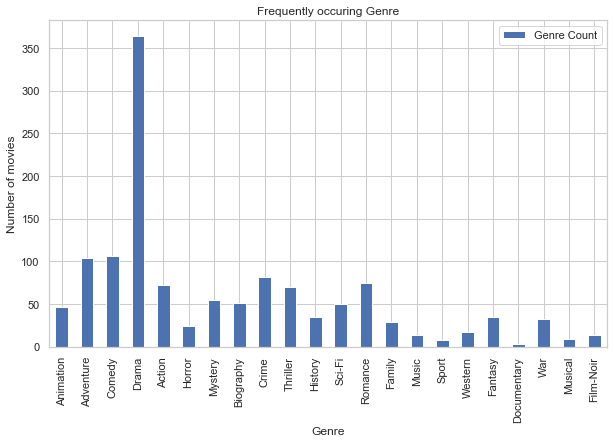

In [164]:
df_genre.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Genre') # add to x-label to the plot
plt.ylabel('Number of movies') # add y-label to the plot
plt.title('Frequently occuring Genre') # add title to the plot

plt.show()

## Rating Distribution

[  9  13  53  96 191 106  31  10   6   2]
[7.1  7.32 7.54 7.76 7.98 8.2  8.42 8.64 8.86 9.08 9.3 ]


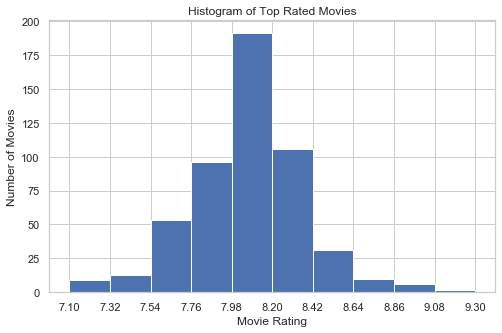

In [165]:
df.sort_values(['Rating'], ascending=False, axis=0, inplace=True)
# np.histogram returns 2 values
count, bin_edges = np.histogram(df['Rating'])

print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins
df['Rating'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)

plt.title('Histogram of Top Rated Movies')
plt.ylabel('Number of Movies') # add y-label
plt.xlabel('Movie Rating') # add x-label

plt.show()

## Country Distribution

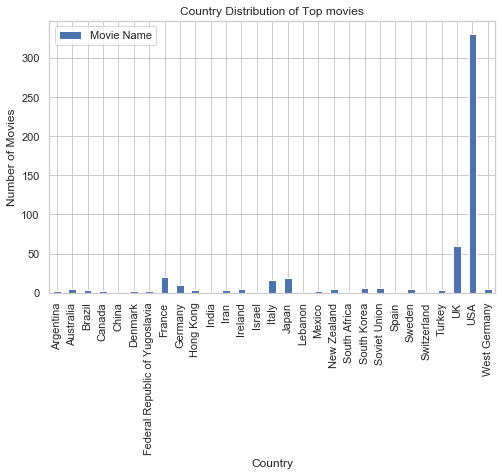

In [166]:
df[['Country','Movie Name']].groupby('Country').count().plot(kind='bar',figsize=(8, 5))
plt.title('Country Distribution of Top movies')
plt.ylabel('Number of Movies') # add y-label
plt.xlabel('Country') # add x-label

plt.show()

## Language Distribution

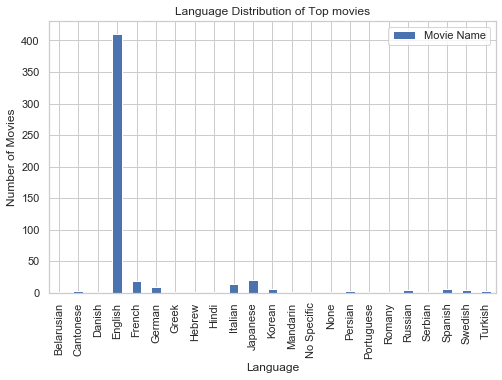

In [167]:
df[['Language','Movie Name']].groupby('Language').count().plot(kind='bar',figsize=(8, 5))
plt.title('Language Distribution of Top movies')
plt.ylabel('Number of Movies') # add y-label
plt.xlabel('Language') # add x-label

plt.show()

## Duration vs Rating

In [168]:
df_dur = pd.DataFrame()
df_dur = df[['Duration', 'Rating']]
df_dur.head()

,Duration,Rating
3,142.0,9.3
1,175.0,9.2
26,202.0,9.0
27,152.0,9.0
19,96.0,8.9


Text(0.5, 1.0, 'Rating Vs Duration')

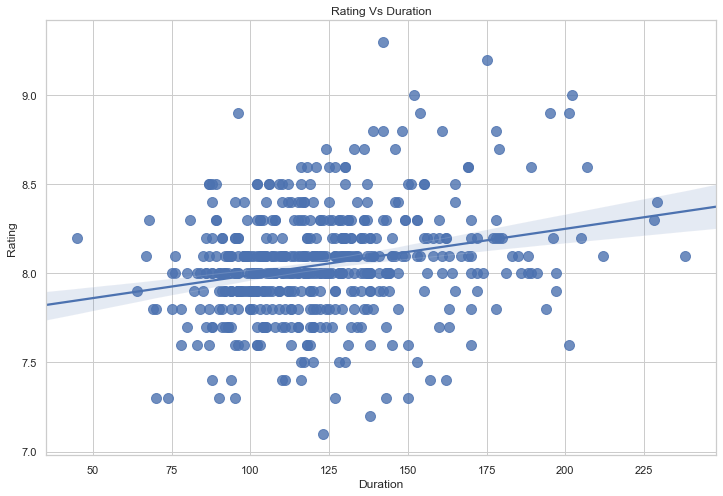

In [169]:
plt.figure(figsize=(12, 8))

sns.set(font_scale=1)
sns.set_style('whitegrid')

ax = sns.regplot(x='Duration', y='Rating', data=df_dur, scatter_kws={'s': 100})
ax.set_title('Rating Vs Duration')

## Year and Rating

In [170]:
df_yr = pd.DataFrame()
df_yr = df[['Year', 'Rating']]
df_yr.head()

,Year,Rating
3,1994,9.3
1,1972,9.2
26,1974,9.0
27,2008,9.0
19,1957,8.9


Text(0.5, 1.0, 'Rating Vs Year')

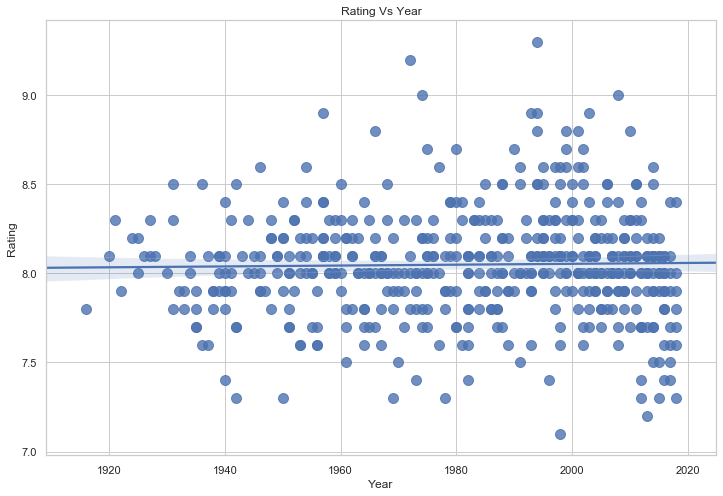

In [171]:
plt.figure(figsize=(12, 8))

sns.set(font_scale=1)
sns.set_style('whitegrid')

ax = sns.regplot(x='Year', y='Rating', data=df_yr, scatter_kws={'s': 100})
ax.set_title('Rating Vs Year')

## Budget vs Rating

In [172]:
df_budget = pd.DataFrame()
df_budget = df[['Budget Value', 'Rating']]
df_budget.head()

,Budget Value,Rating
3,25.00,9.3
1,6.00,9.2
26,13.00,9.0
27,185.00,9.0
19,0.35,8.9


Text(0.5, 1.0, 'Rating Vs Budget')

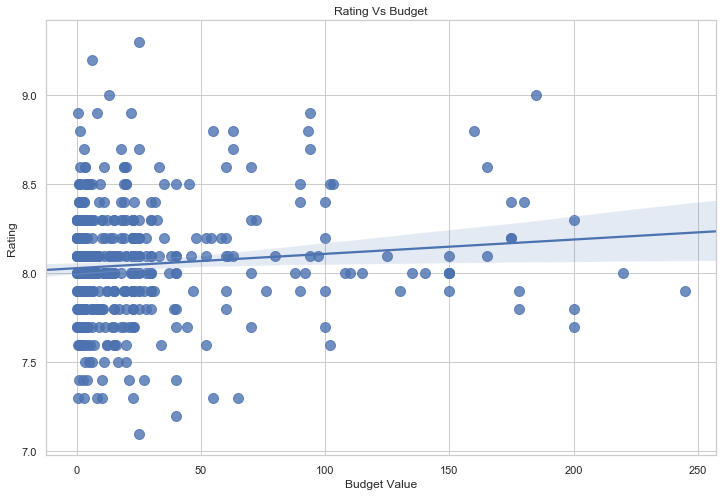

In [173]:
plt.figure(figsize=(12, 8))

sns.set(font_scale=1)
sns.set_style('whitegrid')

ax = sns.regplot(x='Budget Value', y='Rating', data=df_budget, scatter_kws={'s': 100})
ax.set_title('Rating Vs Budget')

## Gross vs Rating

In [174]:
df_gross = pd.DataFrame()
df_gross = df[['Gross', 'Rating']]
df_gross.head()

,Gross,Rating
3,28.341469,9.3
1,134.966411,9.2
26,57.300000,9.0
27,534.858444,9.0
19,4.360000,8.9


Text(0.5, 1.0, 'Rating Vs Gross')

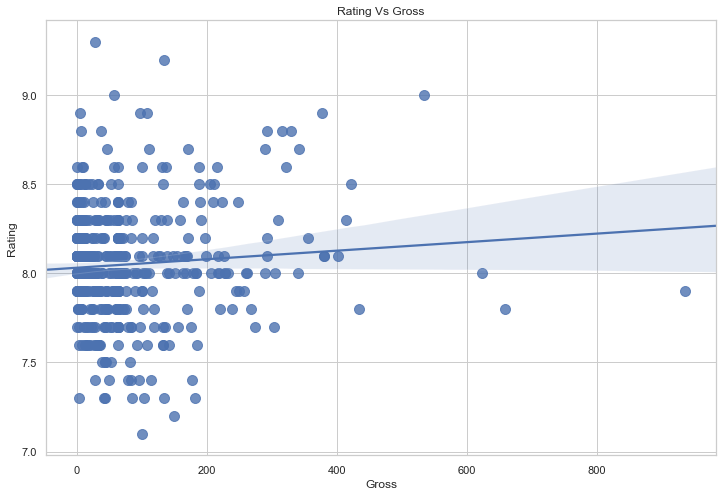

In [175]:
plt.figure(figsize=(12, 8))

sns.set(font_scale=1)
sns.set_style('whitegrid')

ax = sns.regplot(x='Gross', y='Rating', data=df_gross, scatter_kws={'s': 100})
ax.set_title('Rating Vs Gross')

## Budget vs Gross

In [176]:
df_bg = pd.DataFrame()
df_bg = df[['Budget Value', 'Gross']]
df_bg.head()

,Budget Value,Gross
3,25.00,28.341469
1,6.00,134.966411
26,13.00,57.300000
27,185.00,534.858444
19,0.35,4.360000


Text(0.5, 1.0, 'Budget Vs Gross')

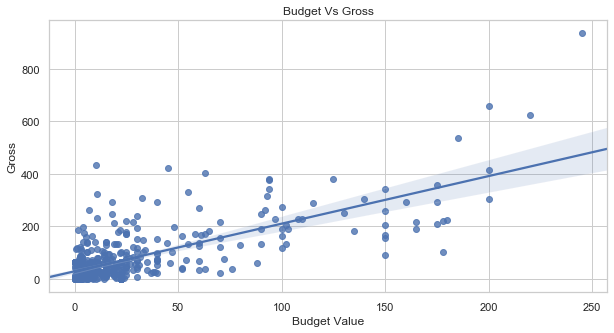

In [177]:
plt.figure(figsize=(10, 5))

sns.set(font_scale=1)
sns.set_style('whitegrid')
ax = sns.regplot(x='Budget Value', y='Gross', data=df_bg)
ax.set_title('Budget Vs Gross')

In [178]:
# calculate the Pearson's correlation between two variables
from scipy.stats import pearsonr
# calculate Pearson's correlation
corr, _ = pearsonr(df['Budget Value'], df['Gross'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.723


## Budget vs Gross for movies released before 2000

Text(0.5, 1.0, 'Budget Vs Gross before 2000')

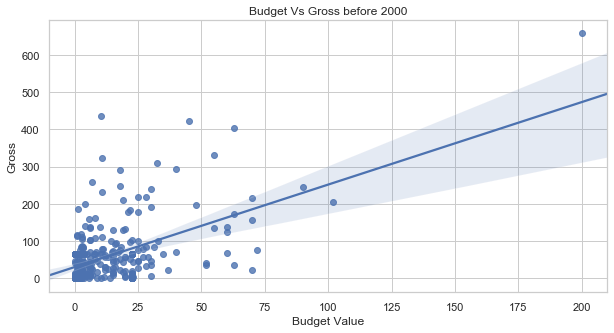

In [179]:
df_bg = pd.DataFrame()
df_bg = before_data[['Budget Value', 'Gross']]
df_bg.head()
plt.figure(figsize=(10, 5))

ax = sns.regplot(x='Budget Value', y='Gross', data=df_bg)
ax.set_title('Budget Vs Gross before 2000')

In [180]:
# calculate the Pearson's correlation between two variables
from scipy.stats import pearsonr
# calculate Pearson's correlation
corr, _ = pearsonr(before_data['Budget Value'], before_data['Gross'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.542


## Budget vs Gross for movies released after 2000

Text(0.5, 1.0, 'Budget Vs Gross after 2000')

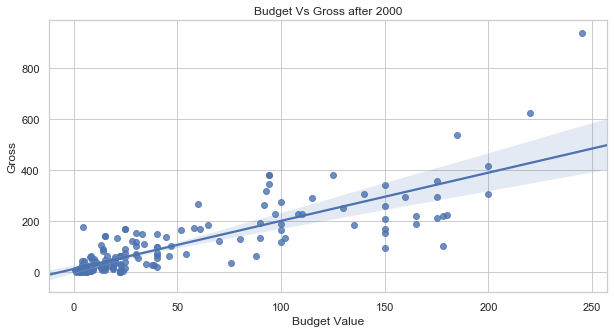

In [181]:
df_bg = pd.DataFrame()
df_bg = after_data[['Budget Value', 'Gross']]
df_bg.head()
plt.figure(figsize=(10, 5))
ax = sns.regplot(x='Budget Value', y='Gross', data=df_bg)
ax.set_title('Budget Vs Gross after 2000')

In [182]:
# calculate the Pearson's correlation between two variables
from scipy.stats import pearsonr
# calculate Pearson's correlation
corr, _ = pearsonr(after_data['Budget Value'], after_data['Gross'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.819


In [186]:
df['Budget Value'] = df['Budget Value'] * 1000000
df['Gross'] = df['Gross'] * 1000000

In [187]:
df_new = df.drop('Budget', axis=1) 

In [190]:
df_new.sort_index(inplace=True)

In [191]:
df_new.to_csv('dataset_after_cleaning_and_analysis.csv')